In [1]:
# 使用 inception-v3 做各种图像的识别
# Inception结构分析：https://blog.csdn.net/u010402786/article/details/52433324
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

images/boyGirl.jpg


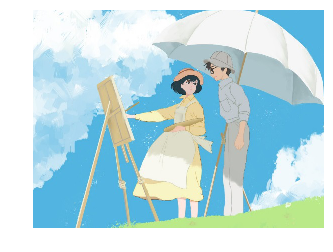

umbrella (score = 0.79306)
ski (score = 0.02903)
parachute, chute (score = 0.02170)
crutch (score = 0.00951)
catamaran (score = 0.00561)

images/boyGirl.png


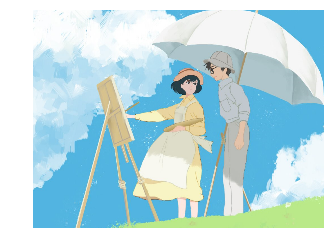

umbrella (score = 0.88870)
ski (score = 0.01132)
parachute, chute (score = 0.01058)
crutch (score = 0.00545)
sunglass (score = 0.00324)

images/CNN结构演化图.jpg


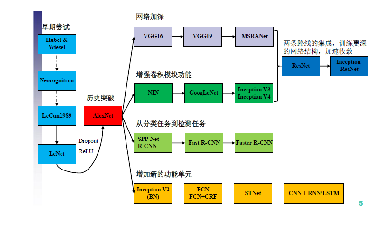

web site, website, internet site, site (score = 0.51742)
crossword puzzle, crossword (score = 0.16428)
remote control, remote (score = 0.01939)
maze, labyrinth (score = 0.01811)
scoreboard (score = 0.01275)

images/convertible .jpg


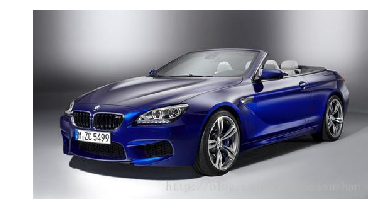

convertible (score = 0.52060)
sports car, sport car (score = 0.33996)
grille, radiator grille (score = 0.01171)
car wheel (score = 0.00246)
amphibian, amphibious vehicle (score = 0.00146)

images/Egyptian cat.jpg


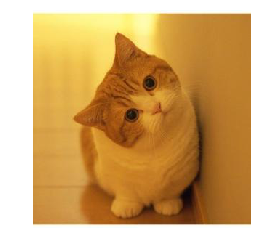

Egyptian cat (score = 0.14247)
tabby, tabby cat (score = 0.07498)
tiger cat (score = 0.06753)
shower curtain (score = 0.02895)
window screen (score = 0.02691)

images/gown.jpg


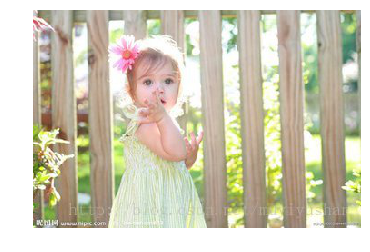

hoopskirt, crinoline (score = 0.12854)
picket fence, paling (score = 0.10552)
gown (score = 0.07657)
broom (score = 0.05566)
maypole (score = 0.05342)



In [3]:
class NodeLookup(object):
    def __init__(self):
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

    def load(self, label_lookup_path, uid_lookup_path):
        # 加载分类字符串 n******** 对应分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        # 一行一行读取数据
        for line in proto_as_ascii_lines:
            # 去掉换行符
            line=line.strip('\n')
            # 按照 '\t' 分割
            parsed_items = line.split('\t')
            # 获取分类编号
            uid = parsed_items[0]
            # 获取分类名称
            human_string = parsed_items[1]
            # 保存编号字符串 n******** 与分类名称映射关系
            uid_to_human[uid] = human_string

        # 加载分类字符串 n******** 对应分类编号 1-1000 的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                # 获取分类编号 1-1000
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                # 获取编号字符串 n********
                target_class_string = line.split(': ')[1]
                # 保存分类编号 1-1000 与编号字符串 n******** 映射关系
                node_id_to_uid[target_class] = target_class_string[1:-2]

        # 建立分类编号 1-1000 对应分类名称的映射关系
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            # 获取分类名称
            name = uid_to_human[val]
            # 建立分类编号 1-1000 到分类名称的映射关系
            node_id_to_name[key] = name
        return node_id_to_name

    # 传入分类编号 1-1000 返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]

# 创建一个图来存放 google 训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name = '')

with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    # 遍历目录
    for root,dirs,files in os.walk('images/'):
        for file in files:
            # 载入图片
            image_data = tf.gfile.FastGFile(os.path.join(root,file), 'rb').read()
            predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data})#图片格式是jpg格式
            predictions = np.squeeze(predictions)#把结果转为1维数据

            # 打印图片路径及名称
            image_path = os.path.join(root, file)
            print(image_path)
            # 显示图片
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            # 排序
            top_k = predictions.argsort()[-5:][::-1]
            node_lookup = NodeLookup()
            for node_id in top_k:
                # 获取分类名称
                human_string = node_lookup.id_to_string(node_id)
                # 获取该分类的置信度
                score = predictions[node_id]
                print('%s (score = %.5f)' % (human_string, score))
            print()